In [ ]:
!pip install tdqm
!pip install detoxify

In [325]:
import pickle
import numpy as np
import pandas as pd
from collections import Counter
import os

import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.figure_factory as ff

import re

from tqdm import tqdm



import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


import pyLDAvis
pyLDAvis.enable_notebook()

from detoxify import Detoxify
toxicity_model = Detoxify('original')

from sklearn.manifold import TSNE
%matplotlib inline

In [236]:
#get pickle files
with open('before_war_vect.pkl', 'rb') as f:
    before_war_vect = pickle.load(f)
with open('war_and_after_vect.pkl', 'rb') as f:
    war_and_after_vect = pickle.load(f)

with open('before_war_sample.pkl', 'rb') as f:
    before_war_sample = pickle.load(f)
with open('war_and_after_sample.pkl', 'rb') as f:
    war_and_after_sample = pickle.load(f)

with open('before_war_tfidf.pkl', 'rb') as f:
    before_war_tfidf = pickle.load(f)
with open('war_and_after_tfidf.pkl', 'rb') as f:
    war_and_after_tfidf = pickle.load(f)

#get the LDA models for before and after
with open('before_war_lda.pkl', 'rb') as f:
    before_war_lda = pickle.load(f)
with open('war_and_after_lda.pkl', 'rb') as f:
    war_and_after_lda = pickle.load(f)


with open('before_war_ngram_tox_dict.pkl', 'rb') as f:
    before_war_ngram_tox_dict = pickle.load(f)
with open('war_and_after_ngram_tox_dict.pkl', 'rb') as f:
    war_and_after_ngram_tox_dict = pickle.load(f)


with open('before_war_ngram_tox_scores.pkl', 'rb') as f:
    before_war_ngram_tox_scores = pickle.load(f)

with open('war_and_after_topic_matrix.pkl', 'rb') as f:
    war_and_after_topic_matrix = pickle.load(f)

In [391]:
#experiment with different lda topics
#seems to be around max_iter 110
before_war_lda2 = LatentDirichletAllocation(n_components=9,
                                   max_iter=80,
                                   doc_topic_prior=0.8, # alpha    
                                   learning_method='online',
                                   random_state = 42)

before_war_lda2.fit(before_war_tfidf)



import pyLDAvis.lda_model

visualize_before = pyLDAvis.lda_model.prepare(before_war_lda2, before_war_tfidf, before_war_vect)
visualize_before

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.256761 -0.058834       1        1  12.272040
8     -0.036001 -0.217477       2        1  11.702506
2      0.247689  0.072077       3        1  11.582915
0     -0.223435 -0.054877       4        1  11.550823
3     -0.089657  0.228423       5        1  11.043523
1     -0.170007 -0.137087       6        1  10.828743
5      0.017499 -0.196951       7        1  10.627171
7     -0.165683  0.248409       8        1  10.501660
6      0.162834  0.116317       9        1   9.890618, topic_info=                         Term          Freq         Total Category  logprob  \
4068         twitter com time  19182.000000  19182.000000  Default  30.0000   
4173             ukraine case  33454.000000  33454.000000  Default  29.0000   
3206            russian starr  33271.000000  33271.000000  Default  28.0000   
1567          invading russia  16440.000000  16440.000000  Default  27.0000   
551              build border  14702.000000  14702.000000  Default  26.0000   
...                       ...           ...           ...      ...      ...   
2252                news euro   4046.989738   5106.574612   Topic9  -3.6281   
4173             ukraine case   4768.837916  33454.412859   Topic9  -3.4639   
3824     troop country border    819.074025   1103.613516   Topic9  -5.2256   
3441     sending troop poland   1061.358106   3687.177920   Topic9  -4.9665   
818   conflict ukraine crisis    675.721595    923.618131   Topic9  -5.4180   

      loglift  
4068  30.0000  
4173  29.0000  
3206  28.0000  
1567  27.0000  
551   26.0000  
...       ...  
2252   2.0810  
4173   0.3655  
3824   2.0154  
3441   1.0683  
818    2.0011  

[347 rows x 6 columns], token_table=      Topic      Freq                        Term
term                                             
97        9  0.998902                amap com feb
108       9  0.999620       amassing troop border
126       6  0.998951               american nato
133       5  0.722086  american ukraine leave say
133       8  0.276562  american ukraine leave say
...     ...       ...                         ...
4940      2  0.998820             withdraws troop
4950      2  0.006223                world leader
4950      9  0.993255                world leader
4959      6  0.999593                 world power
4975      8  0.999163               worry ukraine

[346 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 3, 1, 4, 2, 6, 8, 7])

# LDA Cluster Topic Stats

In [256]:
before_war_topics_all_ngrams = dict()
before_war_feature_names = before_war_vect.get_feature_names_out()
for topic_idx, topic in enumerate(before_war_lda.components_):
    before_war_topics_all_ngrams[topic_idx] = [before_war_feature_names[i] for i in topic.argsort()]

war_and_after_topics_all_ngrams = dict()
after_war_feature_names = war_and_after_vect.get_feature_names_out()
for topic_idx, topic in enumerate(war_and_after_lda.components_):
    war_and_after_topics_all_ngrams[topic_idx] = [after_war_feature_names[i] for i in topic.argsort()[::-1]]

n_top_words = 20
tf_feature_names = war_and_after_vect.get_feature_names_out()
top_20_words = dict()
for topic_idx, topic in enumerate(war_and_after_lda.components_):
    top_20_words[topic_idx] = [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]


# #each toxicity_score in the values is no longer in list form
# before_war_ngram_tox_dict = {ngram: scores[0] for ngram, scores in before_war_ngram_tox_dict.items()}
# war_and_after_ngram_tox_dict = {ngram: scores[0] for ngram, scores in war_and_after_ngram_tox_dict.items()}


In [ ]:
before_war_ngram_tox_dict

In [336]:
#make topic_matrix
before_war_topic_matrix2 = before_war_lda2.fit_transform(before_war_tfidf)

# with open('before_war_topic_matrix.pkl', 'wb') as f:
#      pickle.dump(before_war_topic_matrix, f)


In [251]:
'''
Each doc_vect represents single document's vector in tf-idf matrix (matrix represents corpus for before_war). Each doc_vect is a row in tf-idf matrix, and each column corresponds to a unique ngram/term across before_war dataset. THe values in doc_vect are tf-idf scores for each ngram in that specific document, and the tf-idf scores represent the importance of an ngram within a documnet (the higher the score, the more relevant to the doc). 
'''

before_war_ngram_doc_dict = {} #maps each ngram to the doc it appear in

#iterate through each doc's vector in tf-idf matrix.
for doc_idx, doc_vect in enumerate(before_war_tfidf):
    #find indicies of ngrams whose tfidf_scores !=0.
    ngram_indices = doc_vect.nonzero()[1]  #basically sees which ngrams are present in the document
    for ngram_index in ngram_indices:
        #for non-zero tf-idf scores, it gets corresponding ngram name and maps ngram to current doc (doc_index)
        ngram = feature_names[ngram_index] 
        #if ngram isn't already in ngram_doc_dict, new entry created
        if ngram not in ngram_doc_dict:
            before_war_ngram_doc_dict[ngram] = []
        before_war_ngram_doc_dict[ngram].append(doc_idx)


# before_war_ngram_doc_dict = {}
# feature_names = before_war_vect.get_feature_names_out()
# for doc_idx, doc_vect in enumerate(before_war_tfidf):
#     ngram_indices = doc_vect.nonzero()[1]
#     for ngram_index in ngram_indices:
#         ngram = feature_names[ngram_index]
#         if ngram not in before_war_ngram_doc_dict:
#             before_war_ngram_doc_dict[ngram] = [doc_idx]
#         else:
#             before_war_ngram_doc_dict[ngram].append(doc_idx)

# before_war_ngram_doc_dict

# with open('before_war_doc_topic_dict.pkl', 'wb') as f:
#      pickle.dump(before_war_doc_topic_dict, f)

{'ally russia': [0.0047849924],
 'invade russia': [0.4606724],
 'invades ukraine': [0.5712732],
 'nato amp': [0.0014112486],
 'russia invades': [0.4395982],
 'russia invades ukraine': [0.6309888],
 'russia time': [0.0008086648],
 'care ukraine': [0.040788505],
 'twitter com': [0.0008351117],
 'ukraine twitter': [0.0014109039],
 'ukraine twitter com': [0.0010579394],
 'border say': [0.000822279],
 'mile border': [0.0009948404],
 'troop build': [0.0008095442],
 'amp nato': [0.0017454504],
 'amp russian': [0.011662317],
 'border ukraine': [0.0036471875],
 'border ukraine russian': [0.0025055776],
 'buffer zone': [0.0009577049],
 'control ukraine': [0.04752639],
 'know russia': [0.001671646],
 'nato force': [0.0007509975],
 'russia ukraine': [0.03064128],
 'russia want': [0.14419618],
 'russian border': [0.0013536685],
 'russian border ukraine': [0.006321331],
 'russian security': [0.0014919086],
 'ukraine buffer': [0.011678471],
 'ukraine russian': [0.024500633],
 'ukraine security': [0.0

In [257]:
# def extract_all_ngrams_for_topics(lda_model, feature_names):
#     """
#     Extracts all ngrams for each topic from an LDA model based on their association strengths.

#     Parameters:
#     - lda_model: The trained LDA model.
#     - feature_names: List of ngram names corresponding to columns in the LDA model's input matrix.

#     Returns:
#     - topic_ngrams_dict: A dictionary mapping each topic index to its list of ngrams sorted by their significance.
#     """
#     topic_ngrams_dict = {}
#     for topic_idx, topic in enumerate(lda_model.components_):
#         # Sort ngrams based on their association strength with the topic in descending order
#         sorted_indices = topic.argsort()[::-1]
#         # Map these indices to their corresponding ngram names
#         sorted_ngrams = [feature_names[i] for i in sorted_indices]
#         # Update the dictionary with all ngrams for this topic
#         topic_ngrams_dict[topic_idx] = sorted_ngrams
    
#     return topic_ngrams_dict
# before_war_topic_ngrams_dict = extract_all_ngrams_for_topics(before_war_lda, before_war_feature_names)

In [387]:


# '''
# before_war_doc_topic_dict is a dict that stores association between topics and corresponding docs. Keys are the topic_index and values are list of document indicies that are most closely associated with said topic. 
# '''
#identify which docs belong to which topic based on highest association score.
# before_war_doc_topic_dict = {}  # Maps each topic to its associated documents
# for doc_idx, topic_dist in enumerate(before_war_topic_matrix2):
#     topic = np.argmax(topic_dist)
#     if topic not in before_war_doc_topic_dict:
#         before_war_doc_topic_dict[topic] = []
#     before_war_doc_topic_dict[topic].append(doc_idx)
    


threshold = 0.4
before_war_doc_topic_dict = {}
for doc_idx, topic_dist in enumerate(before_war_topic_matrix2):
    topic = np.argmax(topic_dist)
    if topic_dist[topic] >= threshold:
        if topic not in before_war_doc_topic_dict:
            before_war_doc_topic_dict[topic] = []
        before_war_doc_topic_dict[topic].append(doc_idx)



# def associate_docs_with_topics(topic_ngrams_dict, ngram_doc_dict):
#     """
#     Create a mapping of topics to documents based on the presence of topic-specific ngrams within those documents.

#     Parameters:
#     - topic_ngrams_dict: A dictionary where keys are topic indices and values are lists of ngrams associated with each topic.
#     - ngram_doc_dict: A dictionary mapping ngrams to lists of document indices where each ngram appears.

#     Returns:
#     - doc_topic_dict: A dictionary mapping topics to lists of document indices associated with each topic based on ngrams.
#     """
#     doc_topic_dict = {}
    
#     for topic, ngrams in topic_ngrams_dict.items():
#         # Initialize an empty set to store unique document indices for this topic
#         topic_docs_set = set()
        
#         # For each ngram associated with the topic, get the documents it appears in
#         for ngram in ngrams:
#             if ngram in ngram_doc_dict:
#                 # Update the set with document indices from ngram_doc_dict
#                 topic_docs_set.update(ngram_doc_dict[ngram])
        
#         # Convert the set to a list and assign to the topic in doc_topic_dict
#         doc_topic_dict[topic] = list(topic_docs_set)
    
#     return doc_topic_dict

# before_war_doc_topic_dict = associate_docs_with_topics(before_war_topic_ngrams_dict, ngram_doc_dict)


In [272]:
# before_war_ngram_tox_scores = {ngram: scores[0] for ngram, scores in before_war_ngram_tox_scores.items()}

# topic_toxicity_stats = {}
# for topic, docs in before_war_doc_topic_dict.items():
#     # Aggregate ngrams from documents associated with this topic
#     topic_ngrams = set()
#     for doc in docs:
#         topic_ngrams.update(set(ngram for ngram in ngram_doc_dict if doc in ngram_doc_dict[ngram]))
    
#     # Calculate toxicity statistics for the aggregated ngrams
#     scores = [before_war_ngram_tox_scores[ngram] for ngram in topic_ngrams if ngram in before_war_ngram_tox_scores]
#     min_toxicity = min(scores) if scores else float('inf')
#     max_toxicity = max(scores) if scores else float('-inf')
#     average_toxicity = sum(scores) / len(scores) if scores else 0
#     topic_toxicity_stats[topic] = (min_toxicity, max_toxicity, average_toxicity)


def calculate_topic_toxicity_stats(doc_topic_dict, ngram_doc_dict, ngram_tox_scores):
    """
    Calculate toxicity statistics for each topic.

    :param doc_topic_dict: Dictionary mapping topics to documents.
    :param ngram_doc_dict: Dictionary mapping ngrams to documents they appear in.
    :param ngram_tox_scores: Dictionary mapping ngrams to their toxicity scores.
    :return: A dictionary mapping topics to their toxicity statistics.
    """
    topic_toxicity_stats = {}

    # for topic, docs in doc_topic_dict.items():
    #     # Aggregate ngrams from documents associated with this topic
    #     topic_ngrams = set()
    #     for doc in docs:
    #         topic_ngrams.update(set(ngram for ngram in ngram_doc_dict if doc in ngram_doc_dict[ngram]))
    for topic, docs in doc_topic_dict.items():
        # Initialize an empty set for the topic's unique ngrams
        topic_ngrams = set()
    
        # Iterate over each document associated with the topic
        for doc in docs:
            # Check each ngram to see if the current document is one of the associated documents
            for ngram, doc_indices in ngram_doc_dict.items():
                if doc in doc_indices:
                    topic_ngrams.add(ngram) # If so, add the ngram to the topic's set of ngrams

        # Calculate toxicity statistics for the aggregated ngrams
        scores = [ngram_tox_scores[ngram] for ngram in topic_ngrams if ngram in ngram_tox_scores]
        min_toxicity = min(scores) if scores else float('inf')
        max_toxicity = max(scores) if scores else float('-inf')
        average_toxicity = sum(scores) / len(scores) if scores else 0
        total_toxicity = sum(scores) if scores else 0  # Calculate total toxicity

        # Update the dictionary with the statistics for the current topic
        topic_toxicity_stats[topic] = {
            'min_toxicity': min_toxicity,
            'max_toxicity': max_toxicity,
            'average_toxicity': average_toxicity,
            'total_toxicity': total_toxicity,
            'ngram_count': len(scores)  # Include the count of ngrams for additional insights
        }

    return topic_toxicity_stats


In [274]:
# before_war_ngram_tox_scores = {ngram: scores[0] for ngram, scores in before_war_ngram_tox_scores.items()}

before_war_topic_stats = calculate_topic_toxicity_stats(before_war_doc_topic_dict, before_war_ngram_doc_dict, before_war_ngram_tox_scores)
before_war_topic_stats
# with open('before_war_topic_stats.pkl', 'wb') as f:
#      pickle.dump(before_war_topic_stats, f)

{4: {'min_toxicity': 0.00061138545,
  'max_toxicity': 0.914878,
  'average_toxicity': 0.038159426413249944,
  'total_toxicity': 131.00131087668706,
  'ngram_count': 3433},
 7: {'min_toxicity': 0.00061138545,
  'max_toxicity': 0.914878,
  'average_toxicity': 0.038565512501473095,
  'total_toxicity': 130.27430122997612,
  'ngram_count': 3378},
 3: {'min_toxicity': 0.00061138545,
  'max_toxicity': 0.914878,
  'average_toxicity': 0.03792642184285677,
  'total_toxicity': 130.01177407731302,
  'ngram_count': 3428},
 5: {'min_toxicity': 0.00061138545,
  'max_toxicity': 0.914878,
  'average_toxicity': 0.0379125091598701,
  'total_toxicity': 122.68487964133965,
  'ngram_count': 3236},
 8: {'min_toxicity': 0.00061138545,
  'max_toxicity': 0.914878,
  'average_toxicity': 0.03786218480915976,
  'total_toxicity': 121.38616449816618,
  'ngram_count': 3206},
 1: {'min_toxicity': 0.00061138545,
  'max_toxicity': 0.914878,
  'average_toxicity': 0.039246034699627626,
  'total_toxicity': 127.078660357394

In [ ]:
'''
Collect unqiue ngrams that appear in the documents associated with a specific topic. 
'''

before_war_topic_ngrams_dict = {} # dict that will store "topic_idx, [ngrams in topic]"
#iterate over each doc associated with a given topic
for topic, doc_IDs in before_war_doc_topic_dict.items():
   
    topic_ngrams = set()

    #loop through each doc in the list of doc_IDs that are linked to the current topic under examination
    for doc in doc_IDs:
        #check each ngram to see if the current document is one of the associated documents
        for ngram, doc_indices in before_war_ngram_doc_dict.items(): 
            #checks whther current document (doc) is listed amoung the doc indicies associated 
            #sees if the ngram is present in the current document
            if doc in doc_indices:
                topic_ngrams.add(ngram) #if so, add the ngram to the topic's set of ngrams

    #update the dictionary with the aggregated ngrams for the current topic
    before_war_topic_ngrams_dict[topic] = topic_ngrams

print(before_war_topic_ngrams_dict)


In [389]:
def calculate_toxicity_stats(topic_ngrams_dict, ngram_toxicity_scores):
    """
    Calculate min, max, average, and total toxicity scores for ngrams in each topic.
    
    :param topic_ngrams_dict: Dictionary mapping topics to sets of ngrams.
    :param ngram_toxicity_scores: Dictionary mapping ngrams to their toxicity scores.
    :return: A dictionary with topics as keys and their toxicity statistics as values.
    """
    topic_toxicity_stats = {}
    for topic, ngrams in topic_ngrams_dict.items():
        # Filter out ngrams that have toxicity scores
        filtered_scores = [ngram_toxicity_scores[ngram] for ngram in ngrams if ngram in ngram_toxicity_scores]
        
        if filtered_scores:
            min_score = min(filtered_scores)
            max_score = max(filtered_scores)
            avg_score = sum(filtered_scores) / len(filtered_scores)
            total_score = sum(filtered_scores)
        else:
            # Default values if no ngrams with scores are found
            min_score, max_score, avg_score, total_score = float('inf'), float('-inf'), 0, 0
        
        # Assigning calculated stats to the topic
        topic_toxicity_stats[topic] = {
            'min_toxicity': min_score,
            'max_toxicity': max_score,
            'average_toxicity': avg_score,
            'total_toxicity': total_score,
            'ngram_count': len(filtered_scores)  # Include the count for insight
        }
    return topic_toxicity_stats


In [390]:
# before_war_stats = calculate_toxicity_stats(before_war_topic_ngrams_dict, before_war_ngram_tox_scores)
# for topic, stats in before_war_stats.items():
#     print(f"Topic {topic}:")
#     print(f"  Min Toxicity: {stats['min_toxicity']}")
#     print(f"  Max Toxicity: {stats['max_toxicity']}")
#     print(f"  Average Toxicity: {stats['average_toxicity']}")
#     print(f"  Total Toxicity: {stats['total_toxicity']}")
#     print(f"  Ngram Count: {stats['ngram_count']}")
#     print("-----")

# before_war_ngram_tox_scores
# before_war_stats



before_war_batch_stats = calculate_toxicity_stats(before_war_topic_ngrams_dict, before_war_ngram_tox_dict)
before_war_batch_stats

{4: {'min_toxicity': 0.0006118710734881461,
  'max_toxicity': 0.9973825812339783,
  'average_toxicity': 0.044561316248769044,
  'total_toxicity': 171.7393128227559,
  'ngram_count': 3854},
 7: {'min_toxicity': 0.0006113849231041968,
  'max_toxicity': 0.9973825812339783,
  'average_toxicity': 0.044546098403548826,
  'total_toxicity': 163.84054992825259,
  'ngram_count': 3678},
 3: {'min_toxicity': 0.0006113849231041968,
  'max_toxicity': 0.9973825812339783,
  'average_toxicity': 0.04243271523021802,
  'total_toxicity': 159.8864709874615,
  'ngram_count': 3768},
 5: {'min_toxicity': 0.0006113849231041968,
  'max_toxicity': 0.9973825812339783,
  'average_toxicity': 0.04374646293595426,
  'total_toxicity': 164.13672893570038,
  'ngram_count': 3752},
 8: {'min_toxicity': 0.0006113849231041968,
  'max_toxicity': 0.9973825812339783,
  'average_toxicity': 0.04468117037480033,
  'total_toxicity': 143.51591924385866,
  'ngram_count': 3212},
 1: {'min_toxicity': 0.0006113849231041968,
  'max_toxi

In [377]:
def find_key_by_value_with_floats(my_dict, target_value, tolerance=1e-9):
    for key, value in my_dict.items():
        if abs(value - target_value) < tolerance:
            return key
    return None  # Return None if the value is not found

# shared_min  =0.9973825812339783
shared_min  = 0.0006118710734881461
found_key = find_key_by_value_with_floats(before_war_ngram_tox_dict, shared_min)

if found_min:
    print(f"The key associated with value {shared_min} is: {found_key}")
else:
    print(f"No key found for value {shared_min}.")
    
shared_max  = 0.9973825812339783
found_key = find_key_by_value_with_floats(before_war_ngram_tox_dict, shared_max)

if found_min:
    print(f"The key associated with value {shared_max} is: {found_key}")
else:
    print(f"No key found for value {shared_max}.")



# # Sort the dictionary by its values, creating a list of tuples (ngram, score)
# sorted_ngram_tox_scores = sorted(before_war_ngram_tox_dict.items(), key=lambda item: item[1], reverse=True)
# # Convert the sorted list of tuples back into a dictionary if needed
# sorted_ngram_tox_scores_dict = dict(sorted_ngram_tox_scores)
# # To print the sorted dictionary
# for ngram, score in sorted_ngram_tox_scores:
#     print(f"{ngram}: {score}")

'''

before_war_ngram_tox_scores:
Based on this, the ngrams that are apparently in the topics are 
"peace keeping": 0.00061138545  --> in all topics except topic 2.
"ukraine want war": 0.9148780107498169  --> present in all topics

before_war_ngram_tox_dict:
Based on this, the ngrams that are apparently in the topics are 
"peace talk": 0.0006118710734881461 
"fuck Ukraine": 0.9973825812339783  --> present in all topics
'''


The key associated with value 0.0006118710734881461 is: peace talk
The key associated with value 0.9973825812339783 is: fuck ukraine


'\nBased on this, the ngrams that are apparently in the topics are \n"peace keeping": 0.00061138545  --> in all topics except topic 2.\n"ukraine want war": 0.9148780107498169  --> present in all topics\n'

In [378]:
# let's inspect the ngrams for each topic ---> before_war_topic_ngrams_dict

# def find_key_by_value_with_strings(my_dict, target_value):
#     for key, value in my_dict.items():
#         if value == target_value:
#             return key
#     return None  # Return None if the value is not found

# min_ngram  = "peace keeping"
# found_key = find_key_by_value_with_strings(before_war_topic_ngrams_dict, min_ngram)

# if found_min:
#     print(f"The key associated with value {min_ngram} is: {found_key}")
# else:
#     print(f"No key found for value {min_ngram}.")

# spec_ngram = "peace keeping"
spec_ngram = "fuck ukraine"
topics_with_ngram  = []

for topic_id, ngrams in before_war_topic_ngrams_dict.items():
    if spec_ngram in ngrams:
        topics_with_ngram.append(topic_id)

if topics_with_ngram:
    print(f'The ngram "{spec_ngram}" is present in topics: {topics_with_ngram}')
else:
    print(f'The ngram "{spec_ngram}" is not present in any topic.')


The ngram "fuck ukraine" is present in topics: [4, 7, 3, 5, 8, 1, 2, 6, 0]


# War and after cluster stats

In [247]:
war_and_after_doc_topic_dict = {}  # Maps each topic to its associated documents
for doc_idx, topic_dist in enumerate(war_and_after_topic_matrix):
    topic = np.argmax(topic_dist)
    if topic not in war_and_after_doc_topic_dict:
        war_and_after_doc_topic_dict[topic] = []
    war_and_after_doc_topic_dict[topic].append(doc_idx)

with open('war_and_after_doc_topic_dict.pkl', 'wb') as f:
     pickle.dump(war_and_after_doc_topic_dict, f)

In [246]:
'''
Each doc_vect represents single document's vector in tf-idf matrix (matrix represents corpus for before_war). Each doc_vect is a row in tf-idf matrix, and each column corresponds to a unique ngram/term across before_war dataset. THe values in doc_vect are tf-idf scores for each ngram in that specific document, and the tf-idf scores represent the importance of an ngram within a documnet (the higher the score, the more relevant to the doc). 
'''

war_and_after_ngram_doc_dict = {} #maps each ngram to the doc it appear in

#iterate through each doc's vector in tf-idf matrix.
for doc_idx, doc_vect in enumerate(war_and_after_tfidf):
    #find indicies of ngrams whose tfidf_scores !=0.
    ngram_indices = doc_vect.nonzero()[1]  #basically sees which ngrams are present in the document
    for ngram_index in ngram_indices:
        #for non-zero tf-idf scores, it gets corresponding ngram name and maps ngram to current doc (doc_index)
        ngram = feature_names[ngram_index] 
        #if ngram isn't already in ngram_doc_dict, new entry created
        if ngram not in war_and_after_ngram_doc_dict:
            war_and_after_ngram_doc_dict[ngram] = []
        war_and_after_ngram_doc_dict[ngram].append(doc_idx)

In [250]:
war_and_after_topic_stats = calculate_topic_toxicity_stats(before_war_doc_topic_dict, before_war_ngram_doc_dict, before_war_ngram_tox_scores)

In [163]:
#pull tfidf matrix given some ngrams -> pull ngrams



#right now -> a bunch of ngrams  and topics werein all ngrams exist in all topics
# so we need to have some data structure that can what are the scores for the ngrams that occur in topic 0.
# get scores for ngrams in each topic.
#make sure you see if an ngram exists in each topic 
#also, make sure you know the documents from where each ngram is being pulled from. 

#make dict starting off with topic 0.
#see that dictionary of topics (topi_index) has access to the docs. 




def calculate_cluster_toxicity_stats(topic_ngrams, ngram_toxicity_scores):
    
    total_toxicity = 0
    total_ngram_count = 0
    min_toxicity = float('inf')  # Use 'inf' for comparison in min calculation
    max_toxicity = float('-inf') # Use '-inf' for comparison in max calculation


    toxicity_dict = {}
    min_toxicity = []
    max_toxicity = []
    score_count = 0

    # print(topic_ngrams)
    #see each ngram in the list of ngrams for each topic
    for ngram in topic_ngrams:
        # print(ngram)
        if ngram in ngram_toxicity_scores:
            # Retrieve the list of toxicity scores for this ngram
            score = ngram_toxicity_scores[ngram]
            if score > 0.0:
                toxicity_dict[ngram] = score
                print(ngram, score)
                
                #total_toxicity +=score
                total_ngram_count +=1
                

        total_toxicity+=score
        3
    min_toxicity = min(toxicity_dict.values()) #look into itervalues -> list of values that we can iterate through
    max_toxicity = max(toxicity_dict.values())
    print("/n----END----/n")
    sys.exit()
   # print(min_toxicity)
            
    # Calculate average toxicity, guard against division by zero
    average_toxicity = (total_toxicity / total_ngram_count) if total_ngram_count > 0 else 0

    # Return the calculated statistics
    return min_toxicity, max_toxicity, average_toxicity, total_toxicity, total_ngram_count


before_war_cluster_stats = {}
for topic_idx, ngrams in before_war_topics_all_ngrams.items():
    min_toxicity, max_toxicity, average_toxicity, total_toxicity, ngram_count = calculate_cluster_toxicity_stats(ngrams, before_war_ngram_tox_dict)
    before_war_cluster_stats[topic_idx] = {
        'min_toxicity': min_toxicity,
        'max_toxicity': max_toxicity,
        'average_toxicity': average_toxicity,
        'total_toxicity': total_toxicity,
        'ngram_count': ngram_count
    }

# war_and_after_cluster_stats = {}
# for topic_idx, ngrams in after_war_topics_all_ngrams.items():
#     min_toxicity, max_toxicity, average_toxicity, total_toxicity, ngram_count = calculate_cluster_toxicity_stats(ngrams, war_and_after_ngram_tox_dict)
#     war_and_after_cluster_stats[topic_idx] = {
#         'min_toxicity': min_toxicity,
#         'max_toxicity': max_toxicity,
#         'average_toxicity': average_toxicity,
#         'total_toxicity': total_toxicity,
#         'ngram_count': ngram_count
#     }

before_war_cluster_stats

russia step 0.0419326014816761
stationing troop 0.0006899790023453534
armed force ukraine 0.007332715671509504
occupy democrat 0.018949702382087708
occupied ukraine 0.12403719872236252
war ukraine twitter com 0.010463382117450237
world com 0.0008309464319609106
wordpress com 0.0008748097461648285
war ukraine twitter 0.015866292640566826
world alert 0.0008547580218873918
pot biden 0.07158365845680237
post status 0.0007277490221895278
defend border 0.0073919398710131645
defend country 0.00611857557669282
ukraine russia 0.023844322189688683
world stand 0.008073882199823856
usa today com 0.0009570509428158402
ukraine risk 0.0018762318650260568
invade biden 0.024786779657006264
invade annex 0.018189242109656334
india time com 0.0007314102840609848
armed force 0.0016813427209854126
indication russia 0.0007263389998115599
world sky news 0.0006663576932623982
world stage 0.0007403500494547188
face ongoing russian 0.02305946871638298
crisis ukraine border 0.0010473522124812007
face ongoing russ

NameError: name 'sys' is not defined

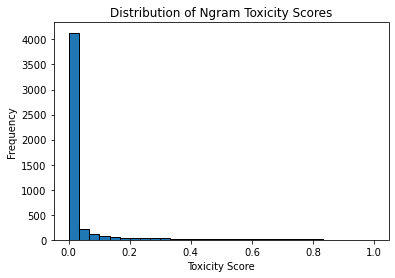

Mean: 0.04426025660688756, Median: 0.0016143139800988138, Std Dev: 0.1262553891606738


In [114]:
# def print_all_ngrams_per_topic(lda_model, feature_names):
#     for topic_idx, topic in enumerate(lda_model.components_):
#         print(f"Topic #{topic_idx}:")
#         # Sort features (ngrams) by their weight/importance within the topic
#         sorted_feature_indices = topic.argsort()[::-1]  # Reverse to get highest first
#         all_features = [feature_names[i] for i in sorted_feature_indices]
#         print(all_features)

# feature_names = before_war_vect.get_feature_names_out()
# print_all_ngrams_per_topic(before_war_lda, feature_names)

import matplotlib.pyplot as plt

scores = list(before_war_ngram_tox_dict.values())
plt.hist(scores, bins=30, edgecolor='k')
plt.xlabel('Toxicity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Ngram Toxicity Scores')
plt.show()


import numpy as np

scores_np = np.array(scores)
print(f"Mean: {np.mean(scores_np)}, Median: {np.median(scores_np)}, Std Dev: {np.std(scores_np)}")


In [ ]:
# def calculate_and_print_topic_toxicity(topic_ngrams, ngram_tox_dict):
#     for topic_idx, ngrams in topic_ngrams.items():
#         print(f"Topic #{topic_idx} Ngrams and Scores:")
#         topic_scores = [ngram_tox_dict[ngram] for ngram in ngrams if ngram in ngram_tox_dict]
#         for ngram, score in zip(ngrams, topic_scores):
#             print(f"{ngram}: {score}")

# calculate_and_print_topic_toxicity(before_war_topics_all_ngrams, before_war_ngram_tox_dict)


topic_scores = {}  # Dictionary to hold lists of scores for each topic

for topic_idx, ngrams in before_war_topics_all_ngrams.items():
    scores = [before_war_ngram_tox_dict[ngram] for ngram in ngrams if ngram in before_war_ngram_tox_dict]
    topic_scores[topic_idx] = scores


import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure to plot multiple distributions
plt.figure(figsize=(12, 8))

# Plotting each topic's distribution of toxicity scores using sns.histplot
for topic_idx, scores in topic_scores.items():
    sns.histplot(scores, kde=True, 
                 label=f'Topic {topic_idx}', element="step", stat="density", common_norm=False)

# Setting the plot's title and labels
plt.title('Distribution of Toxicity Scores by Topic')
plt.xlabel('Toxicity Score')
plt.ylabel('Density')

# Adding a legend
plt.legend()

# Show the plot
plt.show()

In [145]:
topic0_set = set(before_war_topics_all_ngrams[0])
topic1_set = set(before_war_topics_all_ngrams[1])


set()

In [101]:
#simply extracting the avg alone.
topic_toxicity_totals = {}
topic_ngram_counts = {}
#calculate total_toxicity
for topic, ngrams in before_war_topics_all_ngrams.items():
    total_toxicity = sum(before_war_ngram_tox_dict.get(ngram, 0) for ngram in ngrams)
    print(total_toxicity)
    ngram_count = len(ngrams)
    topic_toxicity_totals[topic] = total_toxicity
    topic_ngram_counts[topic] = ngram_count

#calc avg
average_toxicity_scores = {}
for topic in before_war_topics_all_ngrams:
    average_toxicity_scores[topic] = topic_toxicity_totals[topic] / topic_ngram_counts[topic]

print(average_toxicity_scores)


221.3012830344378
221.3012830344378
221.3012830344378
221.3012830344378
221.3012830344378
221.3012830344378
221.3012830344378
221.3012830344378
221.3012830344378
{0: 0.04426025660688756, 1: 0.04426025660688756, 2: 0.04426025660688756, 3: 0.04426025660688756, 4: 0.04426025660688756, 5: 0.04426025660688756, 6: 0.04426025660688756, 7: 0.04426025660688756, 8: 0.04426025660688756}


In [7]:
# no function
topic_toxicity_stats = {}

#get each topic and its ngrams
for topic_idx, ngram_per_topic in before_war_topics_all_ngrams.items():
    # Initialize variables to store the statistics for the current topic
    total_toxicity = 0
    min_toxicity = float('inf')
    max_toxicity = float('-inf')
    ngram_toxicity_scores = []

    for ngram in ngram_per_topic:
        if ngram in before_war_ngram_tox_dict:
            toxicity_score = before_war_ngram_tox_dict[ngram]
            
            #
            total_toxicity += toxicity_score
            
            #update the min and max toxicity scores
            min_toxicity = min(min_toxicity, toxicity_score)
            max_toxicity = max(max_toxicity, toxicity_score)
            
            #append the score to the list for calculating the average later
            ngram_toxicity_scores.append(toxicity_score)
    
    #calc avg
    avg_toxicity = sum(ngram_toxicity_scores) / len(ngram_toxicity_scores) if ngram_toxicity_scores else 0
    
    #store in dict
    topic_toxicity_stats[topic_idx] = {
        'Min': min_toxicity,
        'Max': max_toxicity,
        'Average': avg_toxicity,
        'Total': total_toxicity
    }

topic_toxicity_stats

{0: {'Min': 0.00061138545,
  'Max': 0.914878,
  'Average': 0.038146144982564745,
  'Total': 152.05053390050307},
 1: {'Min': 0.00061138545,
  'Max': 0.914878,
  'Average': 0.038146144982564745,
  'Total': 152.05053390050307},
 2: {'Min': 0.00061138545,
  'Max': 0.914878,
  'Average': 0.038146144982564745,
  'Total': 152.05053390050307},
 3: {'Min': 0.00061138545,
  'Max': 0.914878,
  'Average': 0.038146144982564745,
  'Total': 152.05053390050307},
 4: {'Min': 0.00061138545,
  'Max': 0.914878,
  'Average': 0.038146144982564745,
  'Total': 152.05053390050307},
 5: {'Min': 0.00061138545,
  'Max': 0.914878,
  'Average': 0.038146144982564745,
  'Total': 152.05053390050307},
 6: {'Min': 0.00061138545,
  'Max': 0.914878,
  'Average': 0.038146144982564745,
  'Total': 152.05053390050307},
 7: {'Min': 0.00061138545,
  'Max': 0.914878,
  'Average': 0.038146144982564745,
  'Total': 152.05053390050307},
 8: {'Min': 0.00061138545,
  'Max': 0.914878,
  'Average': 0.038146144982564745,
  'Total': 152.